# BETA Mixed Effects Models
Created: 08/08/24 \
Updated: 08/14/2024 

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08152024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
#### set theme for all plots
# %matplotlib inline
# from matplotlib import rc
# rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("talk")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load Regression DF

In [9]:
band = 'beta'

In [10]:
band_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
band_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [11]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [12]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [13]:
#### filter df by rois with electrode counts >= 50 *** updated to >15
count_thresh = 50

keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
).values>=count_thresh].tolist()

keep_rois


['dmpfc',
 'ofc',
 'acc',
 'sts',
 'hpc',
 'amy',
 'dlpfc',
 'stg',
 'vlpfc',
 'ains',
 'smg',
 'pins',
 'thalamus',
 'mtg']

In [14]:
####### NEW DATA FRAME 
reg_df = band_df.copy()
reg_df = reg_df[reg_df.roi.isin(keep_rois)]
len(reg_df)

222615

In [15]:
np.max(reg_df.band_pow)

6.032583972049991

In [16]:
np.min(reg_df.band_pow)

-0.9714854334507784

# POW ~ Outcome Vars Regressions

In [17]:
# ###### BIC Testing - 
# final_vars   = ['decisionCPE'] # BIC -75963.84280269922
# final_vars   = ['RPE','decisionCPE'] # -76067.74855549095
# final_vars   = ['TrialEV','RPE','decisionCPE'] # -76133.12655751391
# final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE'] # -77928.39857466736
# final_vars   = ['C(TrialType)','TrialEV', 'TotalProfit', 'decisionCPE'] # -76748.27878718339
# final_vars   = ['C(GambleChoice)', 'TrialEV','TotalProfit', 'decisionCPE'] # -77886.00117049165
# final_vars   = ['C(GambleChoice)', 'TrialEV', 'decisionCPE'] # -77162.6616648732
# final_vars   = ['TrialEV', 'TotalProfit', 'decisionCPE'] # -76744.26232072695
# final_vars   = ['C(GambleChoice)', 'decisionCPE'] # -77189.27434340885
# final_vars   = ['TotalProfit', 'decisionCPE'] # -76671.9713105091
# final_vars   = ['TrialEV', 'decisionCPE'] # -76046.95446374474
# final_vars   = ['C(TrialType)','decisionCPE'] # -76024.04129696668
# final_vars   = ['C(TrialType)','TotalProfit', 'decisionCPE'] # -76711.13190240585
# final_vars   = ['C(TrialType)','TrialEV',  'decisionCPE'] # -76066.75006845719


In [18]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

In [19]:
final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic    

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          band_pow  
No. Observations:            222592           Method:                      ML        
No. Groups:                  1620             Scale:                       0.0403    
Min. group size:             65               Log-Likelihood:              37228.7443
Max. group size:             148              Converged:                   Yes       
Mean group size:             137.4                                                   
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.049    0.003 -18.792 0.000 -0.054 -0.044
C(GambleChoice)[T.safe]                   -0.007    0.001  -4.592 0.000 -0.010

-74272.79209003574


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [21]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
final_vars   = ['C(GambleChoice)','TotalProfit','decisionCPE']

In [22]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        final_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [23]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

In [24]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=9.894583145469086, pvalue=6.484210402078498e-19, df=192),
 'dmpfc': TtestResult(statistic=8.842944050248573, pvalue=3.421685164523827e-16, df=215),
 'amy': TtestResult(statistic=3.386460053399241, pvalue=0.0009773577711794372, df=112),
 'sts': TtestResult(statistic=-4.293204373919351, pvalue=3.10326071151315e-05, df=154),
 'ains': TtestResult(statistic=12.725162856759837, pvalue=6.986156546835096e-20, df=70),
 'vlpfc': TtestResult(statistic=8.711072620954706, pvalue=2.961396390464371e-13, df=81),
 'hpc': TtestResult(statistic=0.8032555412424621, pvalue=0.4232495699493579, df=134),
 'mtg': TtestResult(statistic=-5.533755739961557, pvalue=8.600659145559149e-07, df=56),
 'ofc': TtestResult(statistic=9.030616986037668, pvalue=1.413577815879091e-16, df=201),
 'pins': TtestResult(statistic=7.462779591146747, pvalue=4.4471161421399144e-10, df=59),
 'dlpfc': TtestResult(statistic=6.6505930103261095, pvalue=1.3111952502751132e-09, df=106),
 'smg': TtestResult(stati

In [25]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_GambleChoice,raw_TotalProfit,raw_decisionCPE,Intercept,GambleChoice,TotalProfit,decisionCPE,band
0,DA023_lac1-lac2,DA023,acc,14,0.010468,-0.022934,-0.011910,0.009366,0.005940,-0.036715,-0.010789,0.016476,beta
1,DA023_lac2-lac3,DA023,acc,14,0.012990,-0.005137,0.012372,-0.001922,0.008462,-0.018919,0.013494,0.005187,beta
2,DA023_lac3-lac4,DA023,acc,14,0.009755,-0.003247,0.003936,-0.000666,0.005227,-0.017029,0.005057,0.006444,beta
3,MS002_lacas1-lacas2,MS002,acc,14,0.025201,-0.023599,0.014473,0.011434,0.020673,-0.037381,0.015594,0.018544,beta
4,MS002_lacas2-lacas3,MS002,acc,14,0.001900,0.014777,0.014347,0.008303,-0.002627,0.000996,0.015468,0.015413,beta
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,MS050_lcmang3-lcmang4,MS050,thalamus,9,0.015808,-0.013603,-0.007394,0.006588,0.001797,-0.017876,0.007518,0.020857,beta
1616,MS050_lcmang4-lcmang5,MS050,thalamus,9,0.024284,-0.002873,-0.015605,-0.002463,0.010273,-0.007147,-0.000693,0.011807,beta
1617,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,0.015012,0.008354,-0.000320,-0.002796,0.001001,0.004081,0.014592,0.011473,beta
1618,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.005885,-0.008614,-0.000931,0.005393,-0.008126,-0.012888,0.013982,0.019662,beta


In [26]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [27]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [28]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [29]:
fe_results['roi_cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]

In [30]:
fe_results

,Intercept,C(GambleChoice)[T.safe],TotalProfit,decisionCPE,roi,roi_cpe_pval
0,-0.004528,-0.013781,0.001121,0.007110,acc,0.0013
1,-0.035957,-0.008028,0.010429,0.007237,dmpfc,0.0054
2,-0.090480,0.009004,0.011267,0.002061,amy,0.5708
3,-0.068333,-0.030542,0.010173,-0.005110,sts,0.1811
4,0.020492,-0.016308,0.009768,0.024536,ains,0.0000
5,-0.029183,-0.013671,0.005558,0.013400,vlpfc,0.0015
6,-0.121260,0.007560,-0.005729,0.001267,hpc,0.7421
7,-0.095978,-0.025152,0.007508,-0.014429,mtg,0.0162
8,-0.041497,0.000373,0.004784,0.006801,ofc,0.0077
9,-0.058526,0.003954,0.002666,0.019618,pins,0.0002


In [31]:
# bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha = 0.01

bonferr_alpha

0.01

In [32]:
sig_rois = fe_results.roi[fe_results.roi_cpe_pval <= bonferr_alpha].tolist()
sig_rois

['acc', 'dmpfc', 'ains', 'vlpfc', 'ofc', 'pins', 'dlpfc']

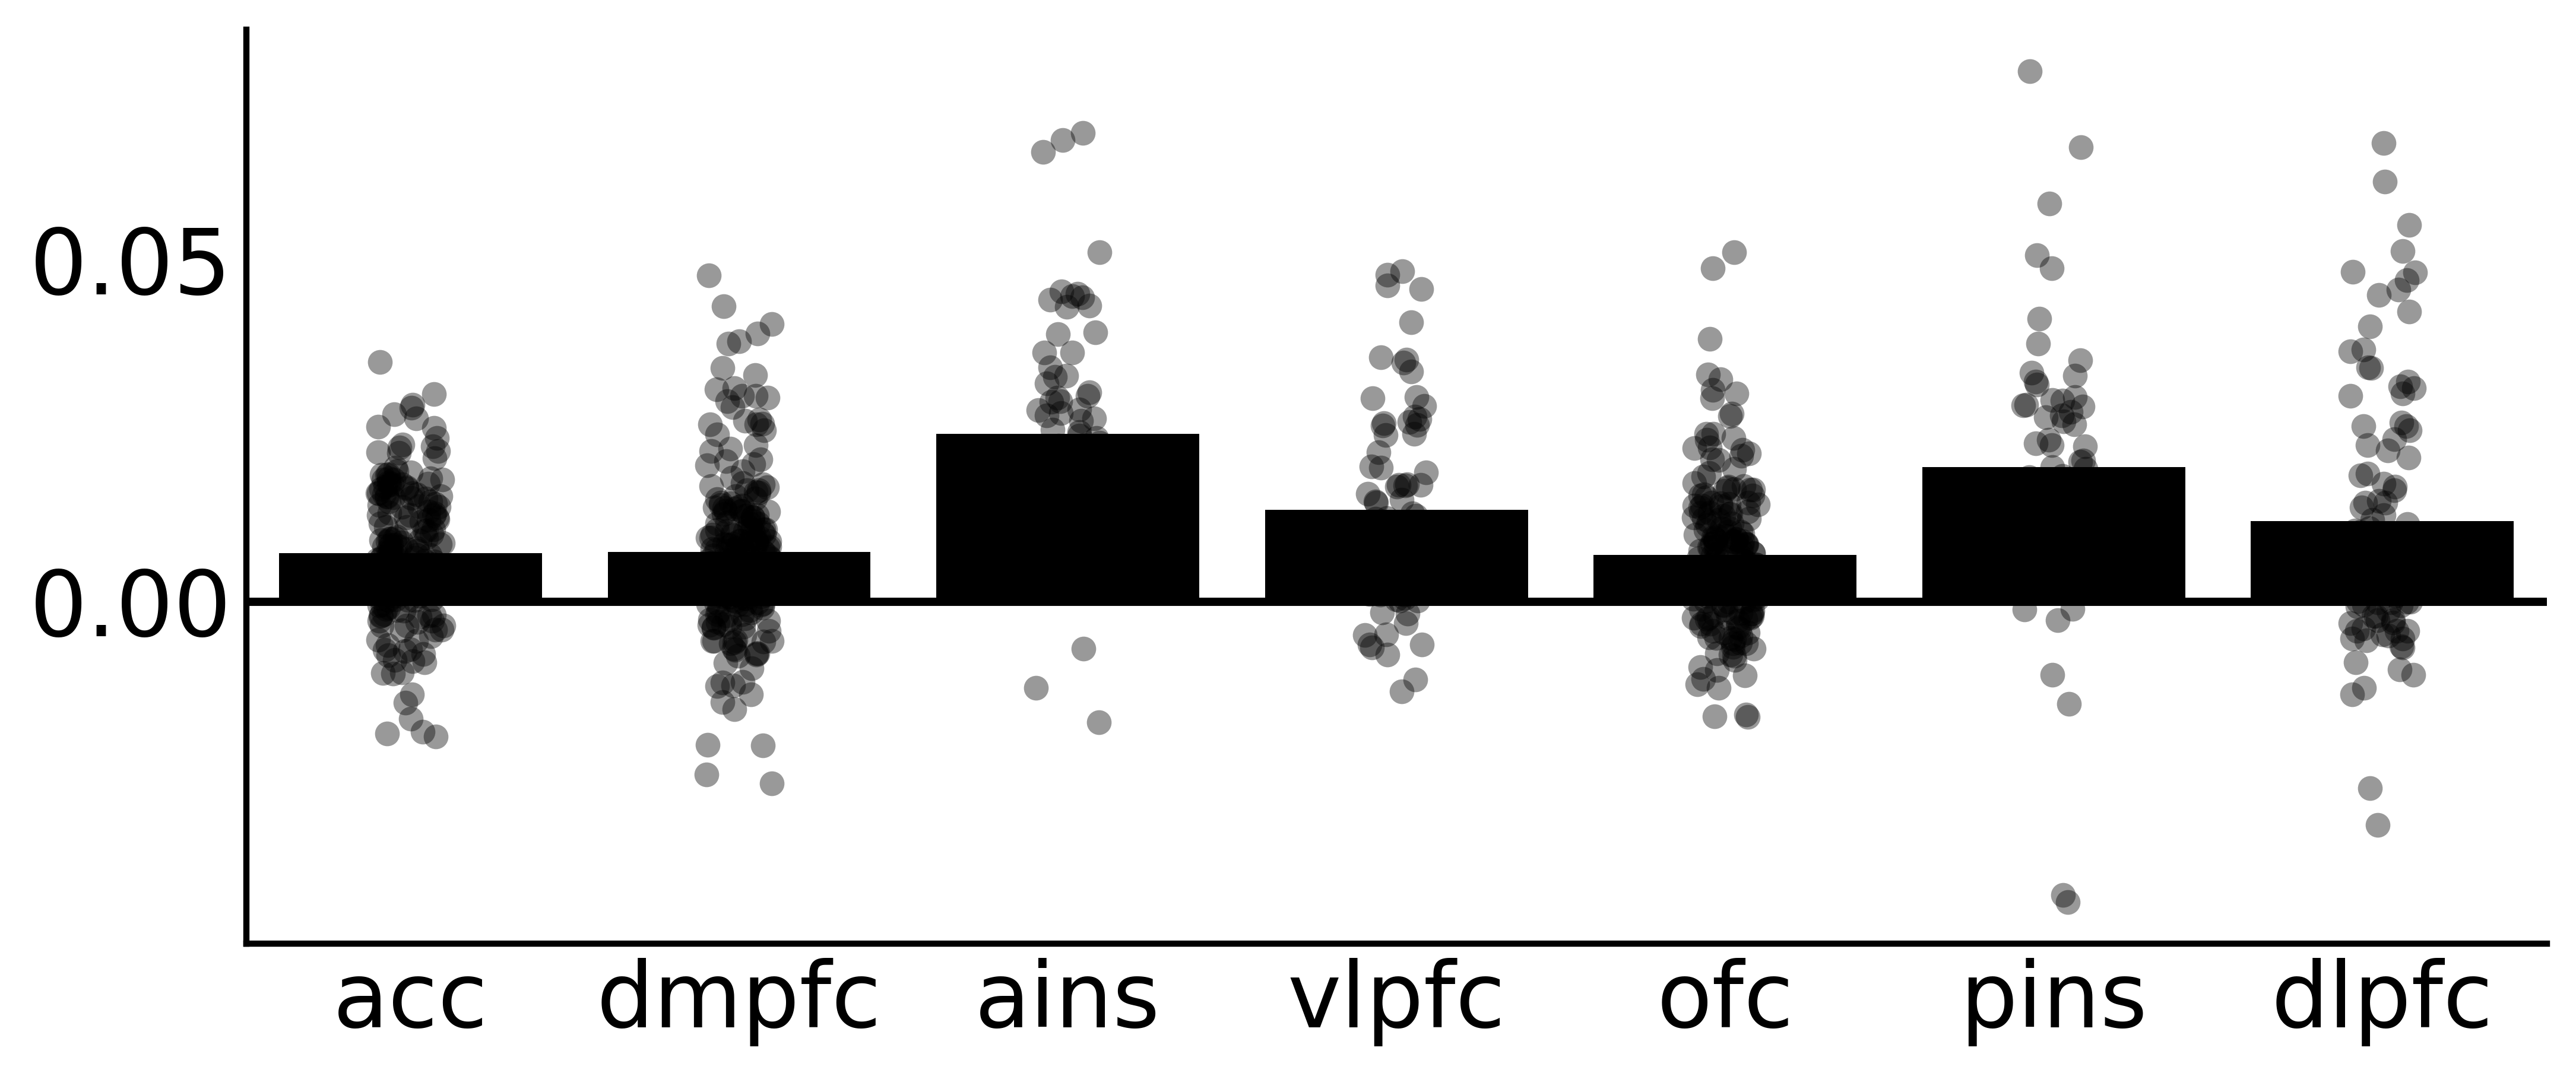

In [33]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=sig_rois)


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


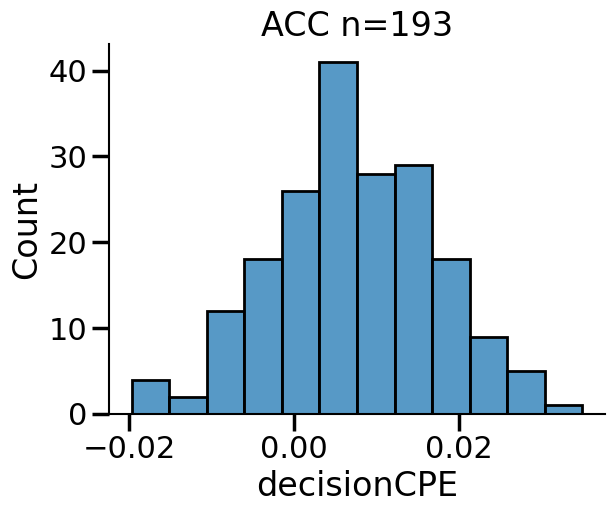

In [34]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
plt.title(f'ACC n={n}')

sns.despine()

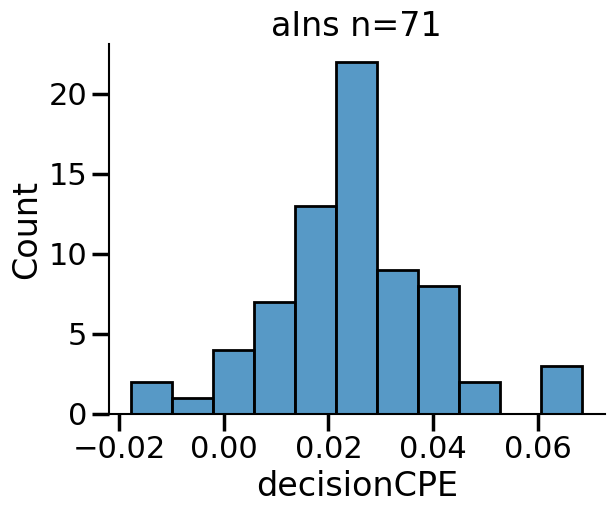

In [35]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'ains'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'ains'].decisionCPE)
plt.title(f'aIns n={n}')

sns.despine()

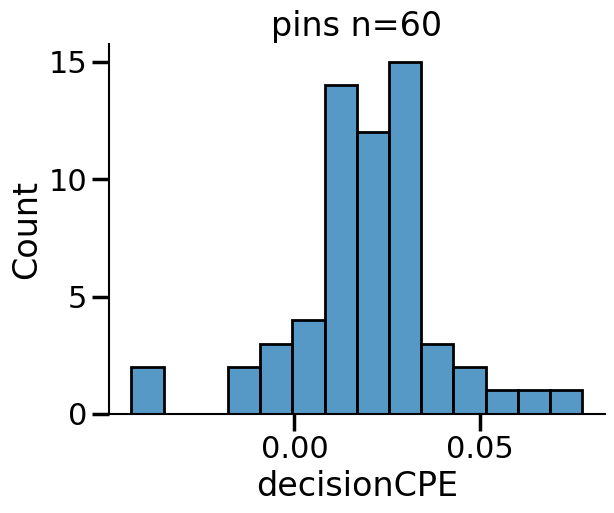

In [36]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'pins'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'pins'].decisionCPE)
plt.title(f'pins n={n}')

sns.despine()

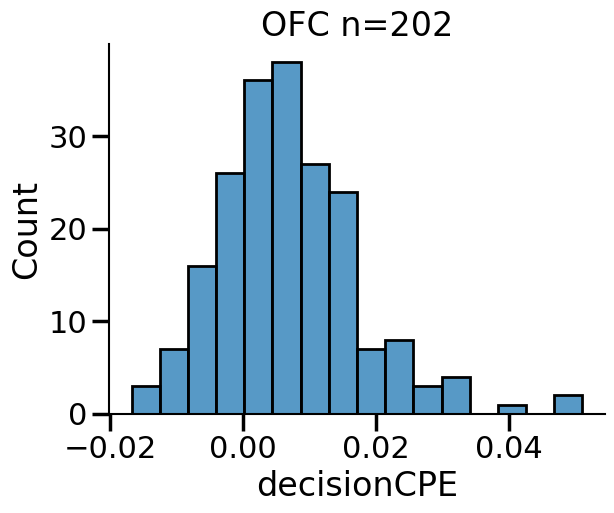

In [37]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
plt.title(f'OFC n={n}')

sns.despine()

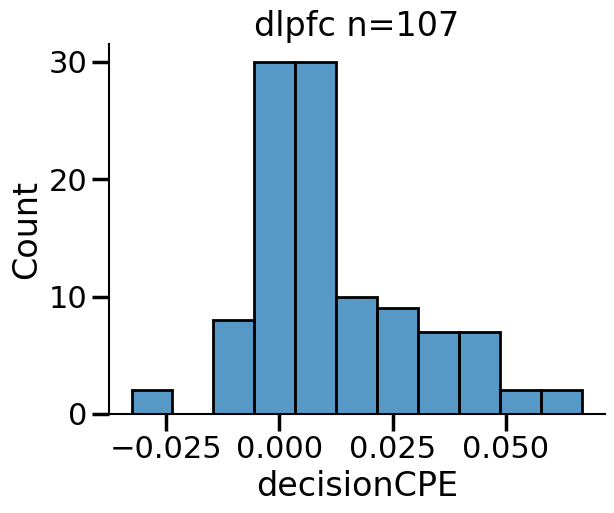

In [38]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'dlpfc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'dlpfc'].decisionCPE)
plt.title(f'dlpfc n={n}')

sns.despine()

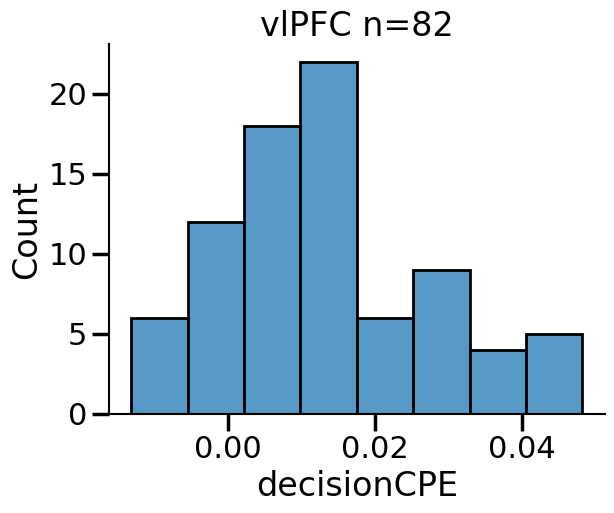

In [39]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'vlpfc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'vlpfc'].decisionCPE)
plt.title(f'vlPFC n={n}')

sns.despine()

In [40]:
sig_rois

['acc', 'dmpfc', 'ains', 'vlpfc', 'ofc', 'pins', 'dlpfc']

In [41]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.2376154383752201 0.000876601375300117
dmpfc pearsonr -0.16624917555316293 0.014436131009598027
amy pearsonr -0.5188553762738193 3.92494494413592e-09
sts pearsonr 0.0007074197345166992 0.9930297580794785
ains pearsonr -0.40082593947719847 0.0005323585601192201
vlpfc pearsonr -0.13492707496996312 0.22681843726616455
hpc pearsonr -0.4509325108207657 4.054403290438529e-08
mtg pearsonr -0.3245406841355249 0.013777467661592676
ofc pearsonr -0.2874146165611686 3.362319248270871e-05
pins pearsonr 0.08667953469656596 0.510195055049227
dlpfc pearsonr -0.11684851225886704 0.2306817401791035
smg pearsonr -0.009950412792073409 0.9367980337366386
stg pearsonr -0.14806445409446306 0.13171609607927268
thalamus pearsonr -0.03081374616338442 0.8183897865093135


In [42]:
sig_rho

[('acc', -0.2376154383752201, 0.000876601375300117),
 ('dmpfc', -0.16624917555316293, 0.014436131009598027),
 ('amy', -0.5188553762738193, 3.92494494413592e-09),
 ('ains', -0.40082593947719847, 0.0005323585601192201),
 ('hpc', -0.4509325108207657, 4.054403290438529e-08),
 ('mtg', -0.3245406841355249, 0.013777467661592676),
 ('ofc', -0.2874146165611686, 3.362319248270871e-05)]

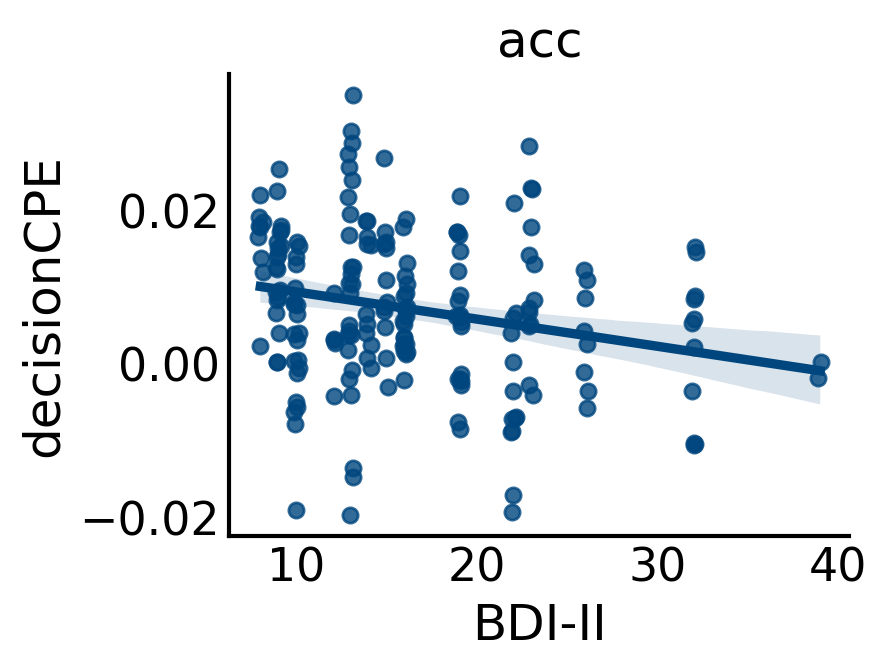

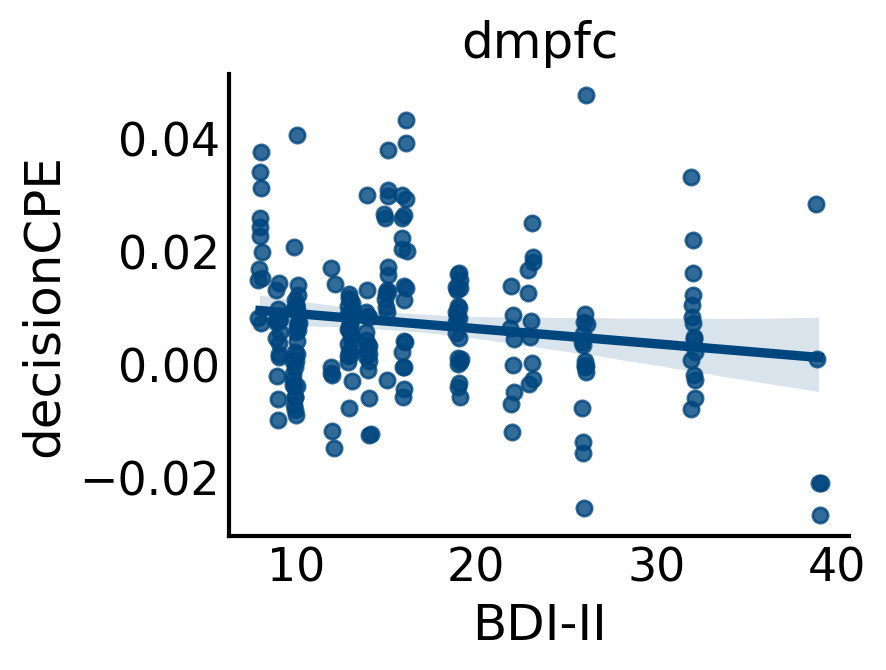

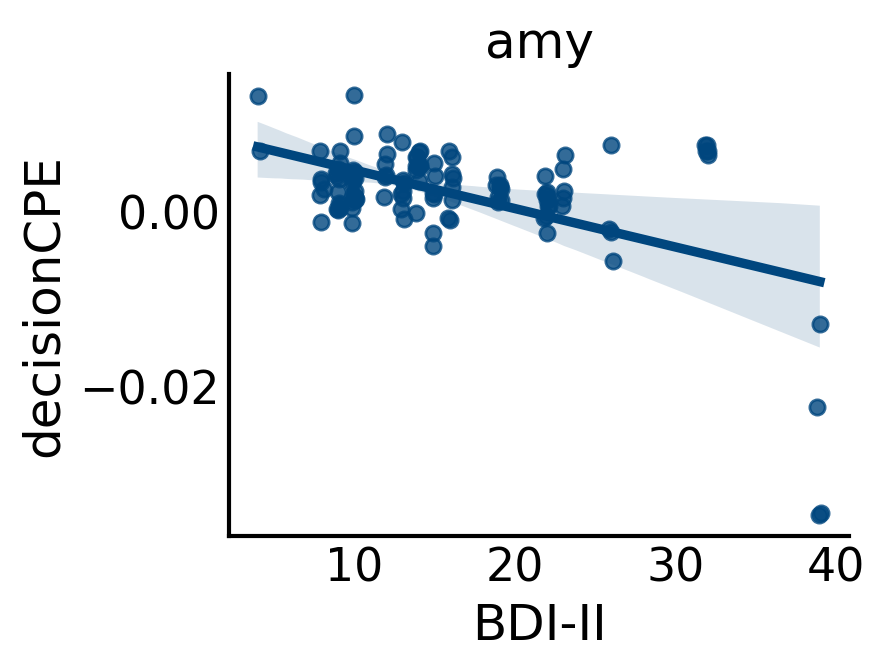

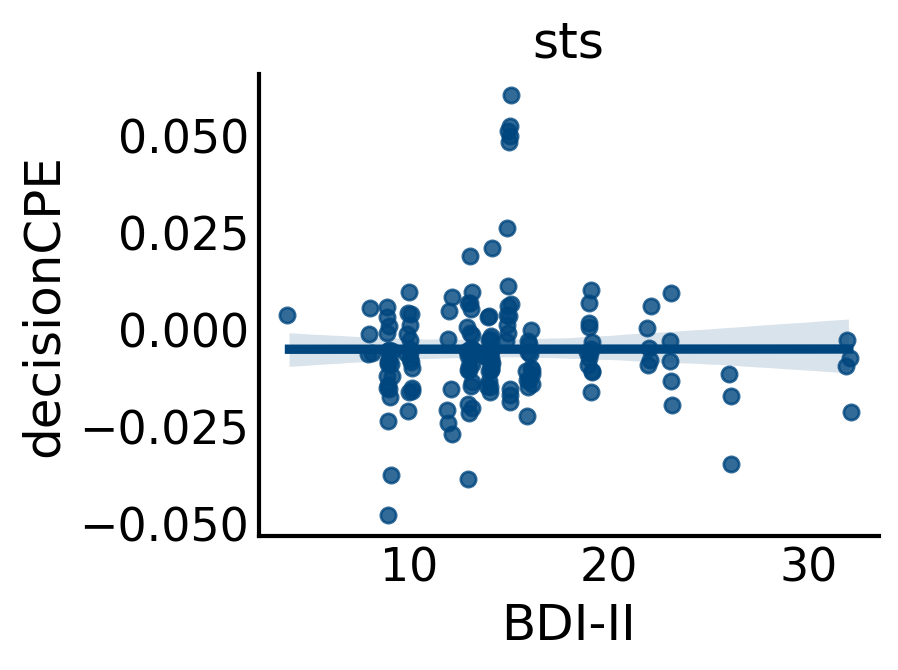

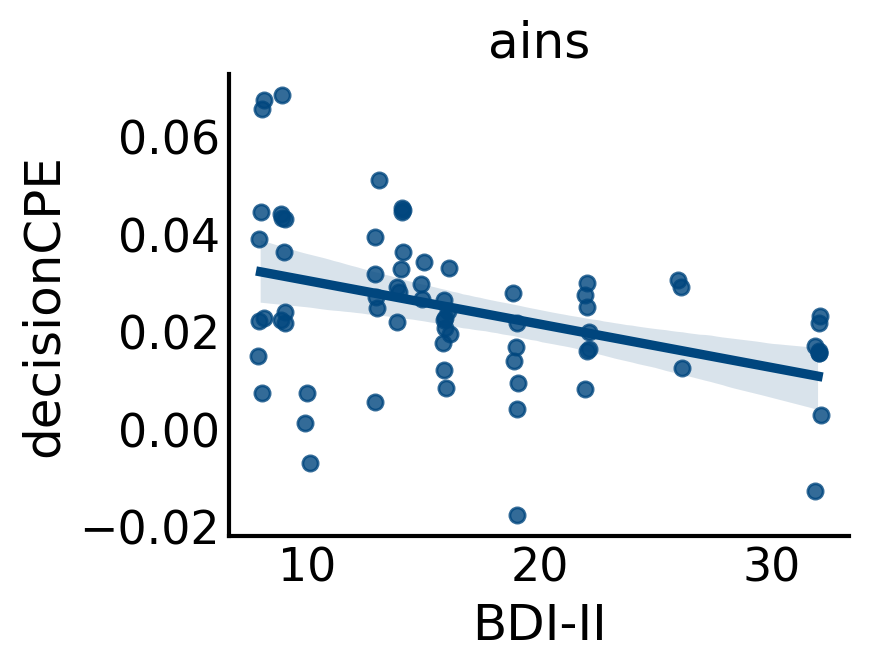

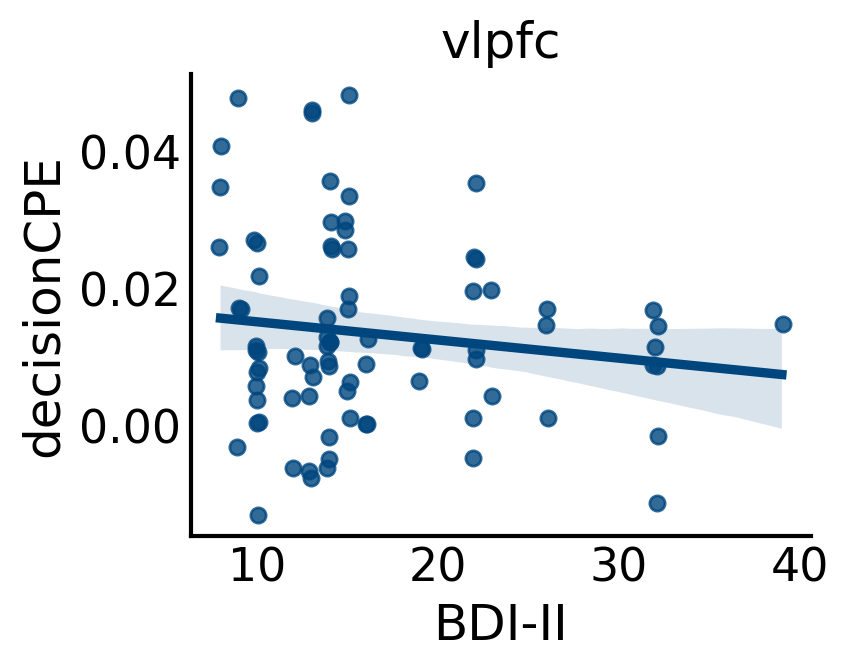

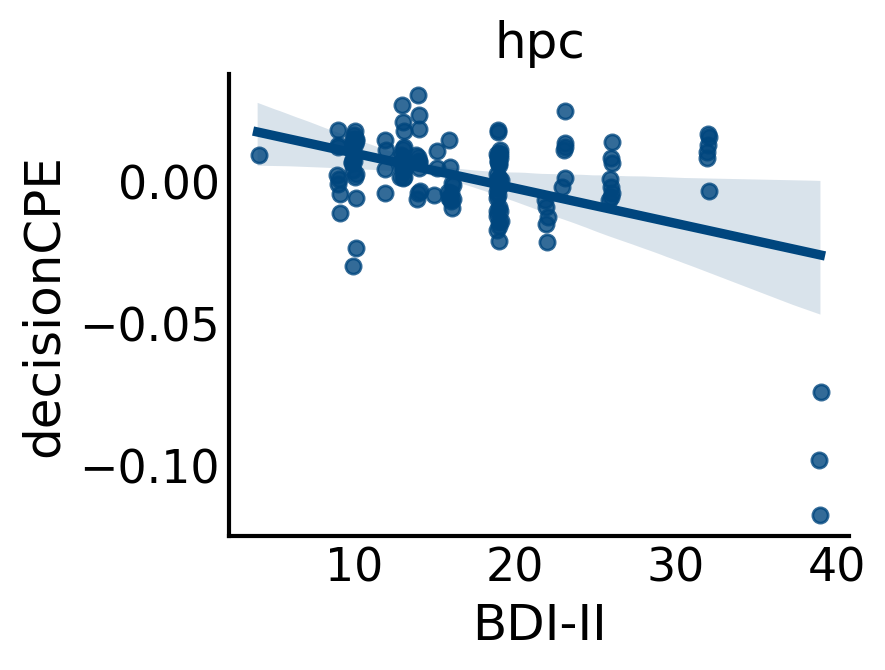

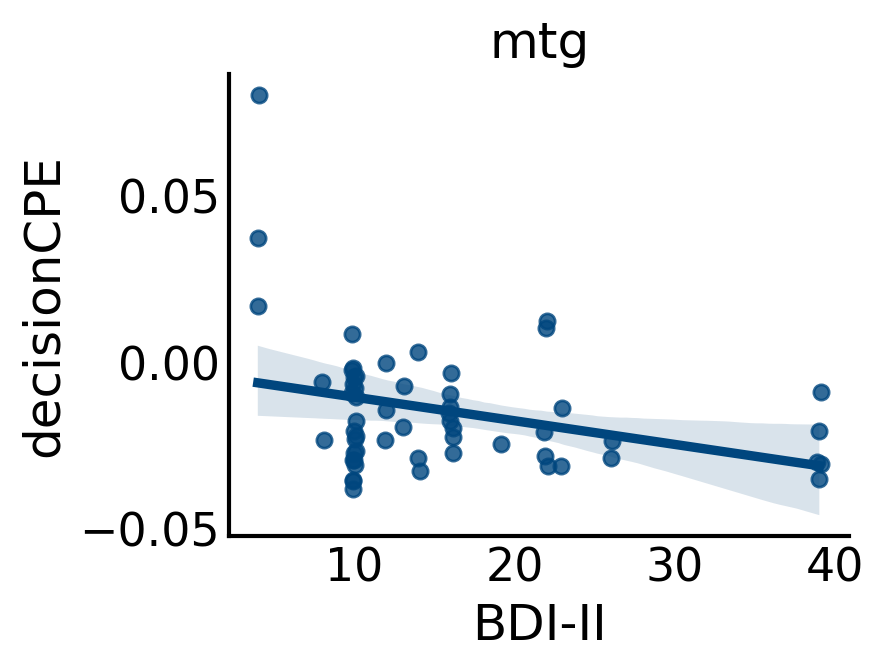

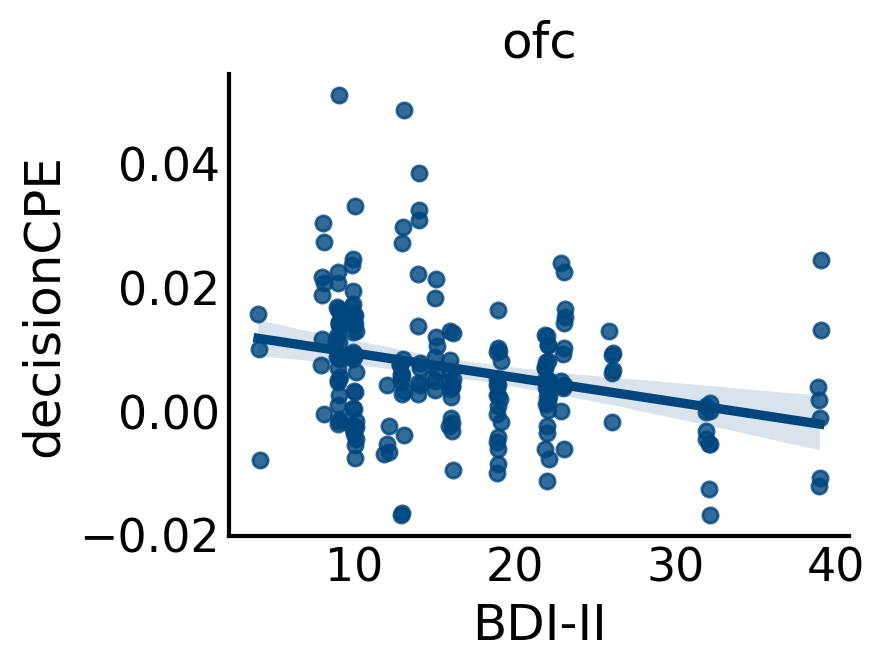

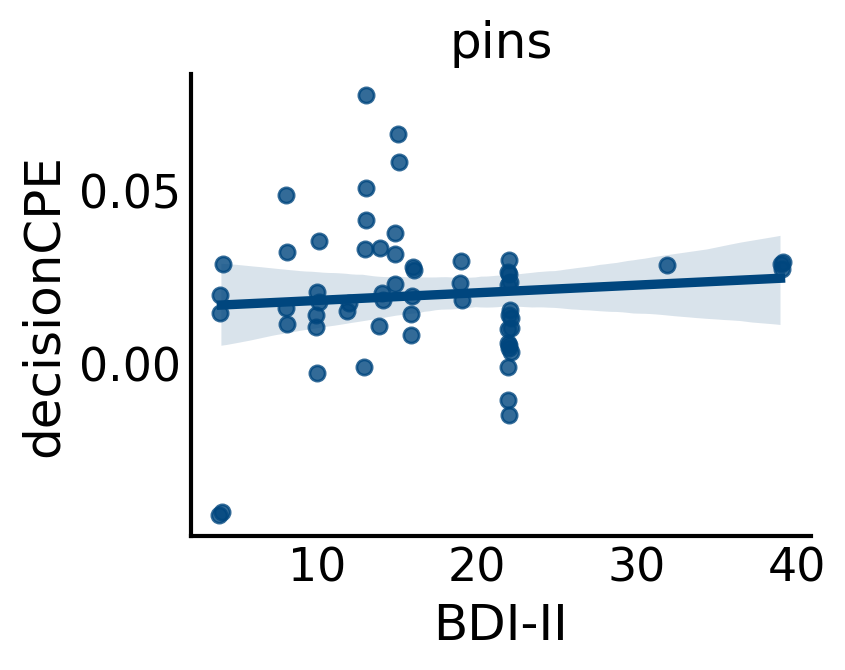

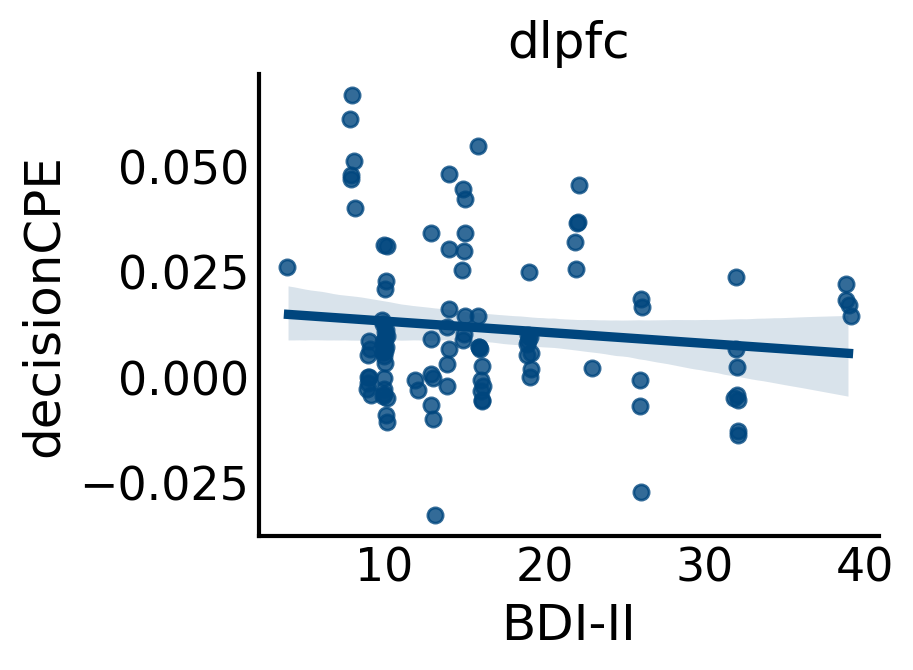

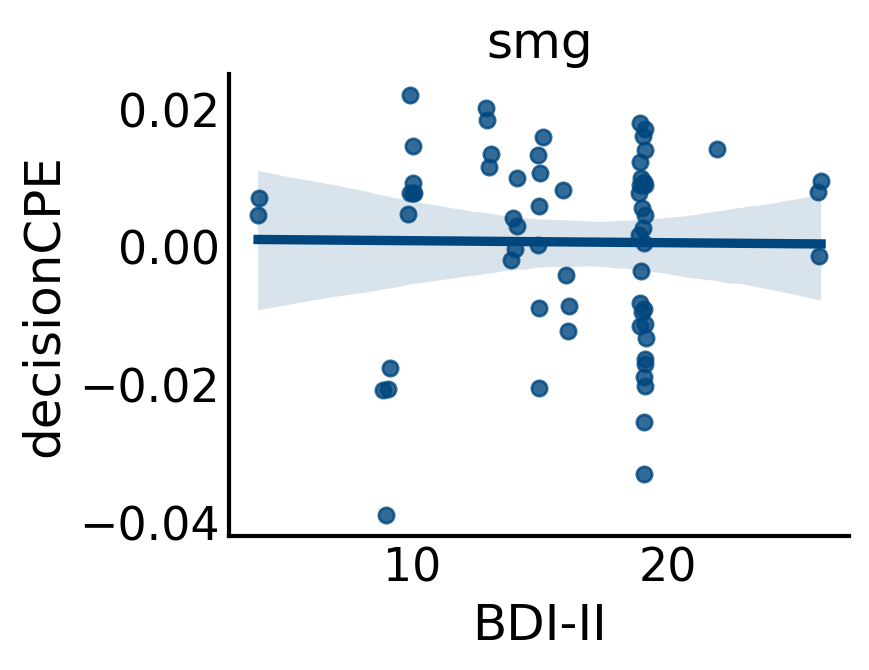

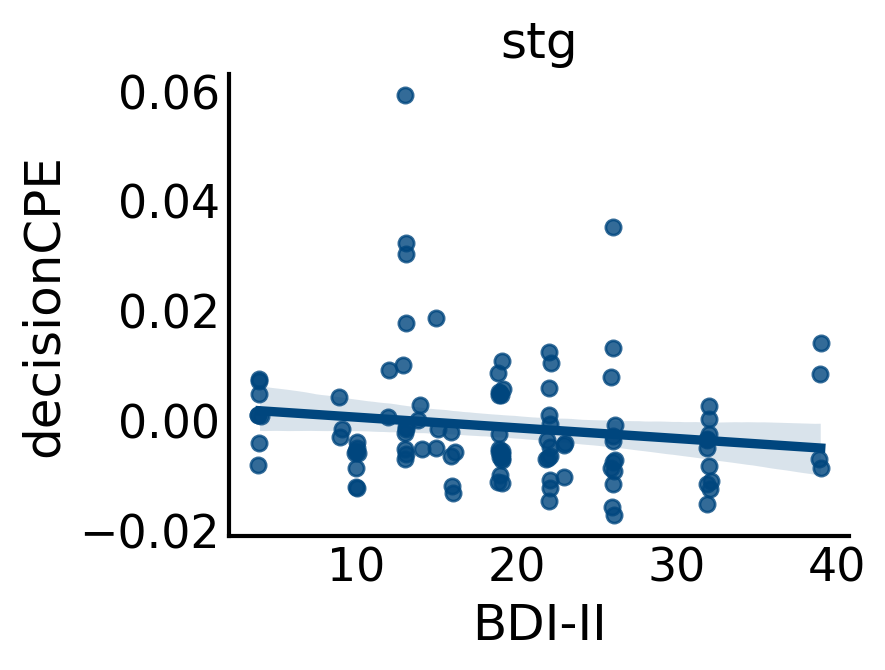

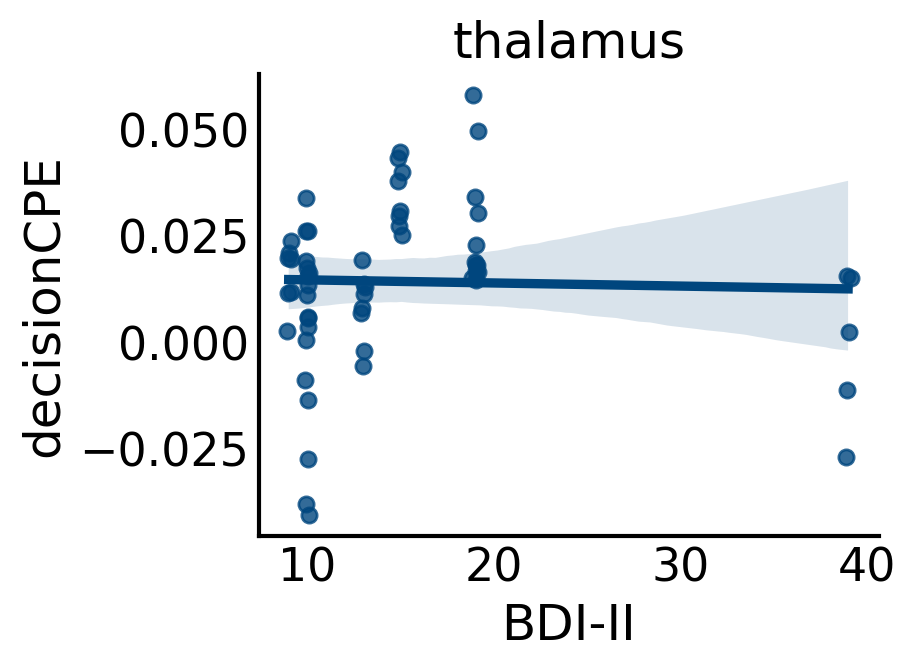

In [43]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    

# RT ~ CPE:Pow Regressions

In [44]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

In [45]:
# rt_vars   = ['TrialEV','decisionCPE','band_pow','decisionCPE:band_pow']
rt_vars   = ['decisionCPE','band_pow','decisionCPE:band_pow']
rt_fit = fit_mixed_model(reg_df,rt_vars,outcome_var,rand_eff_var,reml=False)
print(rt_fit.summary())
rt_fit.bic    

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         logRT_t1   
No. Observations:          222592          Method:                     ML         
No. Groups:                1620            Scale:                      0.1327     
Min. group size:           65              Log-Likelihood:             -95126.2942
Max. group size:           148             Converged:                  No         
Mean group size:           137.4                                                  
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               1.030    0.006 166.878 0.000  1.018  1.042
decisionCPE                             0.039    0.002  20.151 0.000  0.035  0.042
band_pow                   

190437.2847501717


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [46]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
rt_vars   = ['decisionCPE','band_pow','decisionCPE:band_pow']


In [47]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        rt_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [48]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}RT_{band}_roi_results.csv')

In [49]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_decisionCPE,raw_band_pow,raw_decisionCPE:band_pow,Intercept,decisionCPE,band_pow,decisionCPE:band_pow,band
0,DA023_lac1-lac2,DA023,acc,14,-0.119281,0.002525,0.014762,0.033173,0.900384,0.035166,-0.016092,0.038701,beta
1,DA023_lac2-lac3,DA023,acc,14,-0.118306,0.002960,0.009369,0.020827,0.901359,0.035601,-0.021486,0.026355,beta
2,DA023_lac3-lac4,DA023,acc,14,-0.118259,0.003792,0.000907,-0.017174,0.901406,0.036433,-0.029947,-0.011646,beta
3,MS002_lacas1-lacas2,MS002,acc,14,-0.286930,0.002263,0.025618,-0.034378,0.732735,0.034904,-0.005236,-0.028850,beta
4,MS002_lacas2-lacas3,MS002,acc,14,-0.286134,0.004049,0.014426,-0.081699,0.733531,0.036690,-0.016429,-0.076171,beta
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,MS050_lcmang3-lcmang4,MS050,thalamus,9,0.272840,0.034304,0.015984,-0.026641,1.273883,0.089940,0.036788,0.022930,beta
1616,MS050_lcmang4-lcmang5,MS050,thalamus,9,0.272406,0.036694,0.047765,-0.118968,1.273449,0.092330,0.068569,-0.069396,beta
1617,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,0.272446,0.035499,0.063202,-0.065095,1.273489,0.091135,0.084005,-0.015523,beta
1618,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.272449,0.035729,-0.040129,-0.040088,1.273492,0.091365,-0.019325,0.009483,beta


In [50]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results['decisionCPE:band_pow'][roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=2.2805220820871477, pvalue=0.023675159758659584, df=192),
 'dmpfc': TtestResult(statistic=0.8721648034560484, pvalue=0.3840914133627472, df=215),
 'amy': TtestResult(statistic=13.332466632196997, pvalue=7.28789913757092e-25, df=112),
 'sts': TtestResult(statistic=5.504495160234861, pvalue=1.5139091027063396e-07, df=154),
 'ains': TtestResult(statistic=91.7447409619048, pvalue=1.1257657250416825e-74, df=70),
 'vlpfc': TtestResult(statistic=-7.6629264968910755, pvalue=3.453511228929514e-11, df=81),
 'hpc': TtestResult(statistic=9.972405343868619, pvalue=7.342490002722546e-18, df=134),
 'mtg': TtestResult(statistic=1.0609432524000861, pvalue=0.29327003833626164, df=56),
 'ofc': TtestResult(statistic=5.748448037989876, pvalue=3.306863434255826e-08, df=201),
 'pins': TtestResult(statistic=-1.9362227023335419, pvalue=0.05763535361612117, df=59),
 'dlpfc': TtestResult(statistic=-1.8551057335693006, pvalue=0.06635998913806683, df=106),
 'smg': TtestResult(statisti

In [51]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_decisionCPE,raw_band_pow,raw_decisionCPE:band_pow,Intercept,decisionCPE,band_pow,decisionCPE:band_pow,band
0,DA023_lac1-lac2,DA023,acc,14,-0.119281,0.002525,0.014762,0.033173,0.900384,0.035166,-0.016092,0.038701,beta
1,DA023_lac2-lac3,DA023,acc,14,-0.118306,0.002960,0.009369,0.020827,0.901359,0.035601,-0.021486,0.026355,beta
2,DA023_lac3-lac4,DA023,acc,14,-0.118259,0.003792,0.000907,-0.017174,0.901406,0.036433,-0.029947,-0.011646,beta
3,MS002_lacas1-lacas2,MS002,acc,14,-0.286930,0.002263,0.025618,-0.034378,0.732735,0.034904,-0.005236,-0.028850,beta
4,MS002_lacas2-lacas3,MS002,acc,14,-0.286134,0.004049,0.014426,-0.081699,0.733531,0.036690,-0.016429,-0.076171,beta
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,MS050_lcmang3-lcmang4,MS050,thalamus,9,0.272840,0.034304,0.015984,-0.026641,1.273883,0.089940,0.036788,0.022930,beta
1616,MS050_lcmang4-lcmang5,MS050,thalamus,9,0.272406,0.036694,0.047765,-0.118968,1.273449,0.092330,0.068569,-0.069396,beta
1617,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,0.272446,0.035499,0.063202,-0.065095,1.273489,0.091135,0.084005,-0.015523,beta
1618,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.272449,0.035729,-0.040129,-0.040088,1.273492,0.091365,-0.019325,0.009483,beta


In [52]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [53]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [54]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [55]:
fe_results['roi_cpepow_pval'] = [roi_fit_dict[roi].pvalues['decisionCPE:band_pow'] for roi in fe_results.roi.tolist()]


In [56]:
fe_results

,Intercept,decisionCPE,band_pow,decisionCPE:band_pow,roi,roi_cpepow_pval
0,1.019665,0.032641,-0.030854,0.005528,acc,0.857576
1,0.991627,0.049763,-0.063075,0.002162,dmpfc,0.932959
2,1.040546,0.045165,-0.023044,0.078722,amy,0.016879
3,1.042940,0.021988,-0.048361,0.017225,sts,0.452403
4,0.997911,0.045060,-0.010576,0.107539,ains,0.005097
5,1.018592,0.031801,-0.026473,-0.055367,vlpfc,0.148501
6,0.995225,0.040327,-0.027309,0.037456,hpc,0.275097
7,1.086260,0.050162,-0.012910,0.011598,mtg,0.819519
8,1.038790,0.038420,-0.034464,0.031266,ofc,0.178611
9,1.100538,0.024704,-0.006924,-0.029993,pins,0.500517


In [57]:
bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha

0.0035714285714285718

In [58]:
sig_rois = fe_results.roi[fe_results.roi_cpepow_pval <= bonferr_alpha].tolist()
sig_rois

['smg']

In [65]:
# plot_roi_model_results(roi_fit_results,'roi','decisionCPE:band_pow')


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


In [ ]:
# # plot ROI beta distribution
# sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# plt.title(f'ACC n={n}')

# sns.despine()

In [59]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data['decisionCPE:band_pow'])
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.14397839630408005 0.045755837191179066
dmpfc pearsonr 0.0820287052074908 0.22990644886378414
amy pearsonr 0.0976474694879716 0.303514018610813
sts pearsonr 0.08129550326250803 0.31461105027726455
ains pearsonr 0.20115088111501686 0.09255272693719326
vlpfc pearsonr -0.056795877528237525 0.612279483237573
hpc pearsonr 0.22947015108420274 0.007423316640614251
mtg pearsonr -0.08970029331213726 0.5069730073651701
ofc pearsonr 0.2895039867705702 2.9288197465052666e-05
pins pearsonr -0.029116229285279138 0.8252202904039656
dlpfc pearsonr -0.1484209928604771 0.12708219732395024
smg pearsonr -0.16414166378962003 0.1878496398470795
stg pearsonr -0.2943806999125249 0.0023018475894391786
thalamus pearsonr 0.14291378259506787 0.2845243211981895


In [60]:
sig_rho

[('acc', -0.14397839630408005, 0.045755837191179066),
 ('hpc', 0.22947015108420274, 0.007423316640614251),
 ('ofc', 0.2895039867705702, 2.9288197465052666e-05),
 ('stg', -0.2943806999125249, 0.0023018475894391786)]

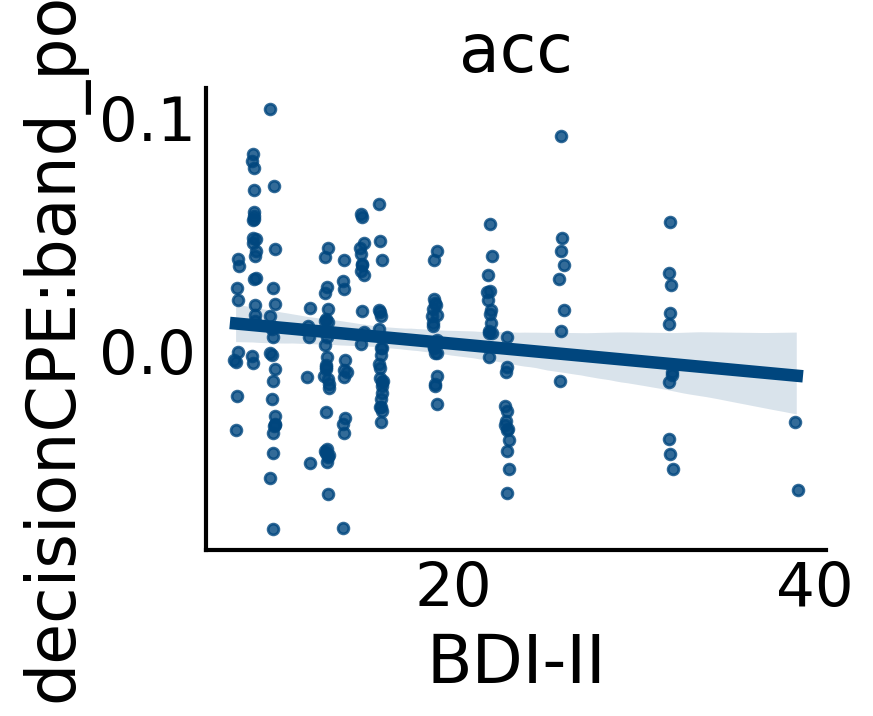

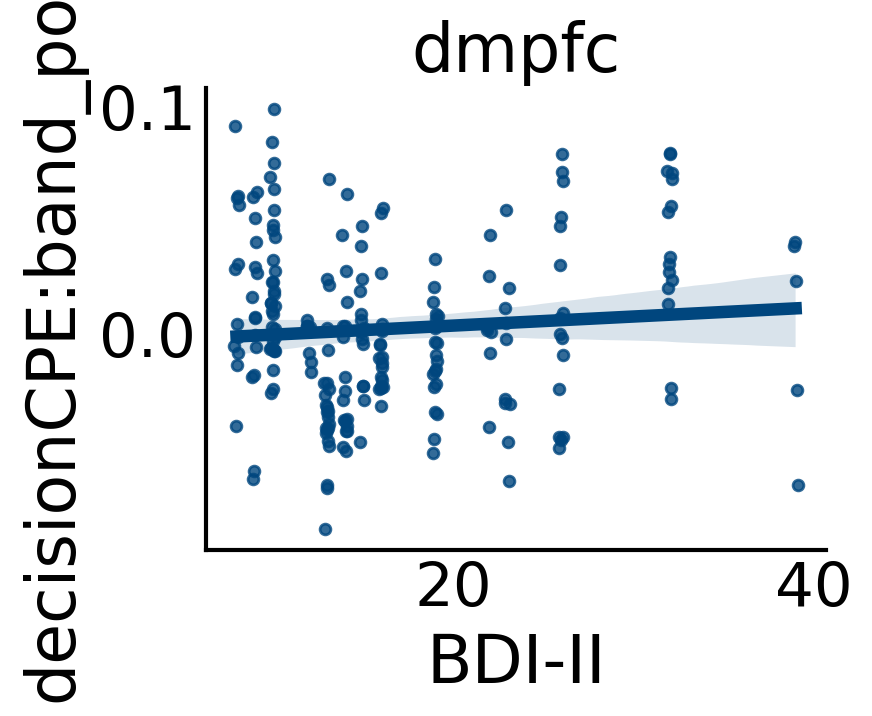

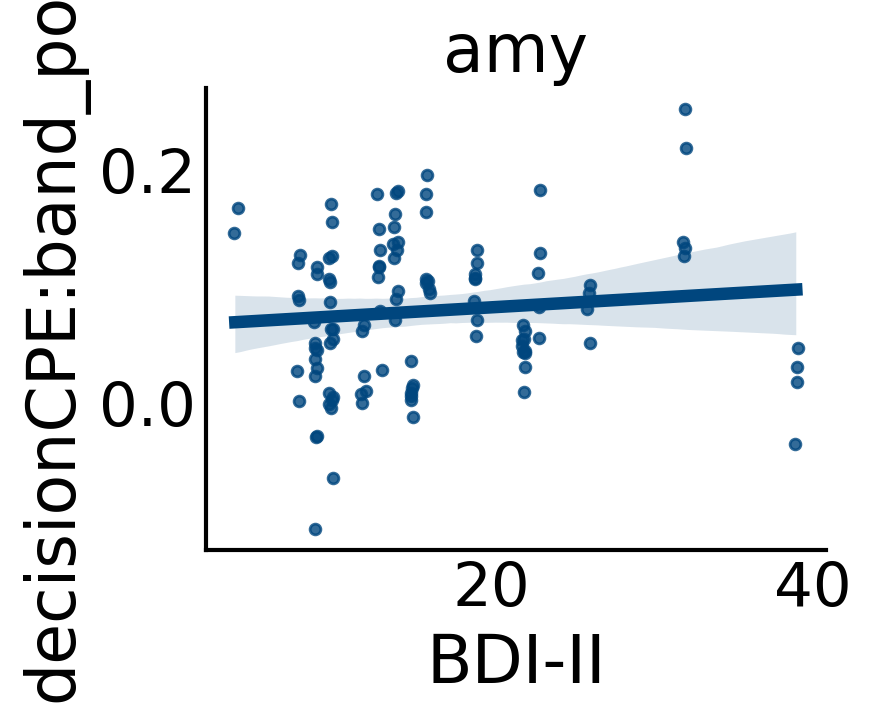

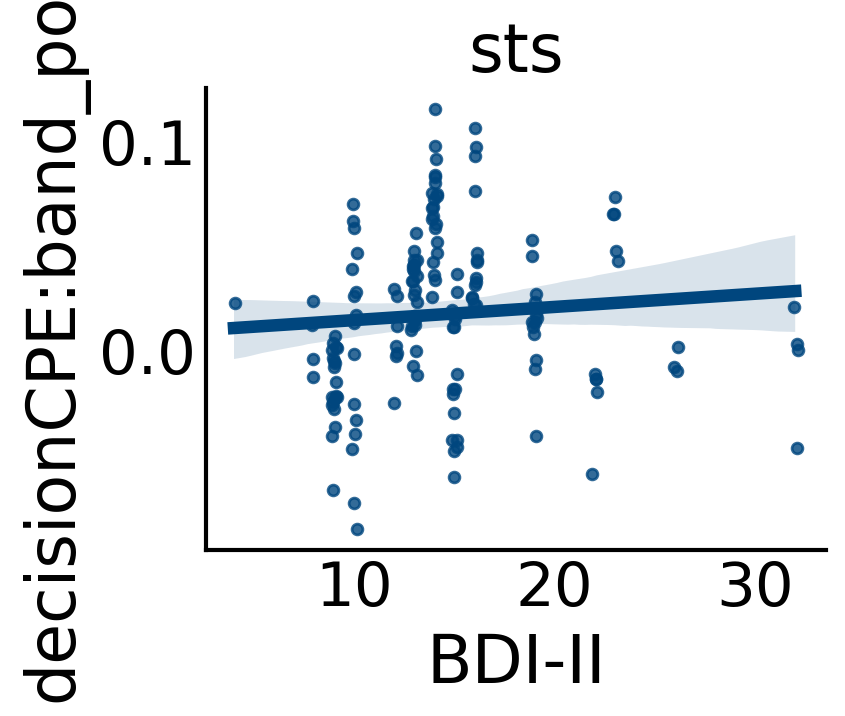

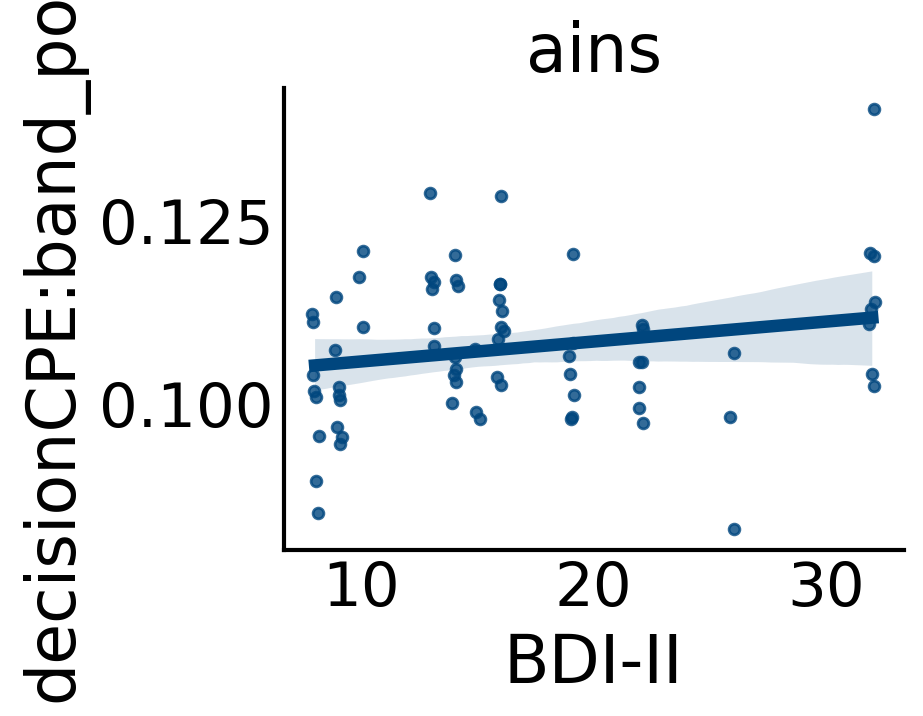

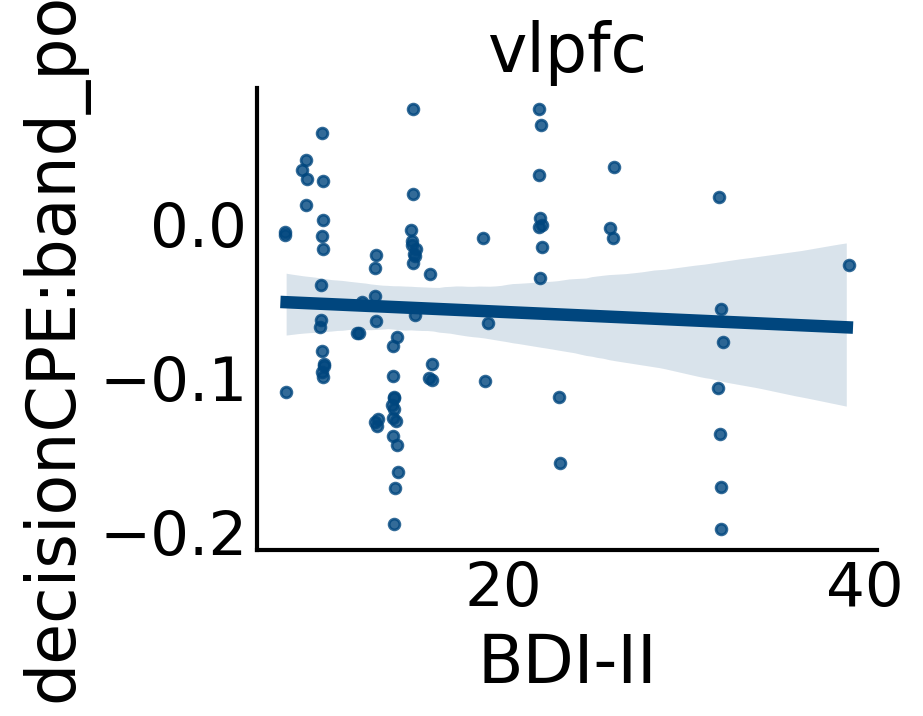

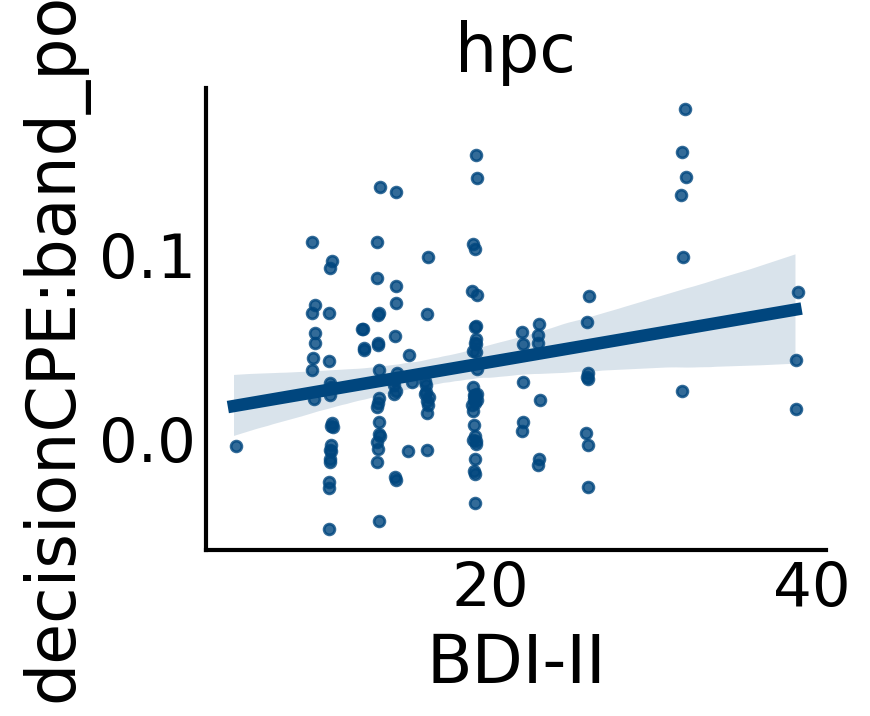

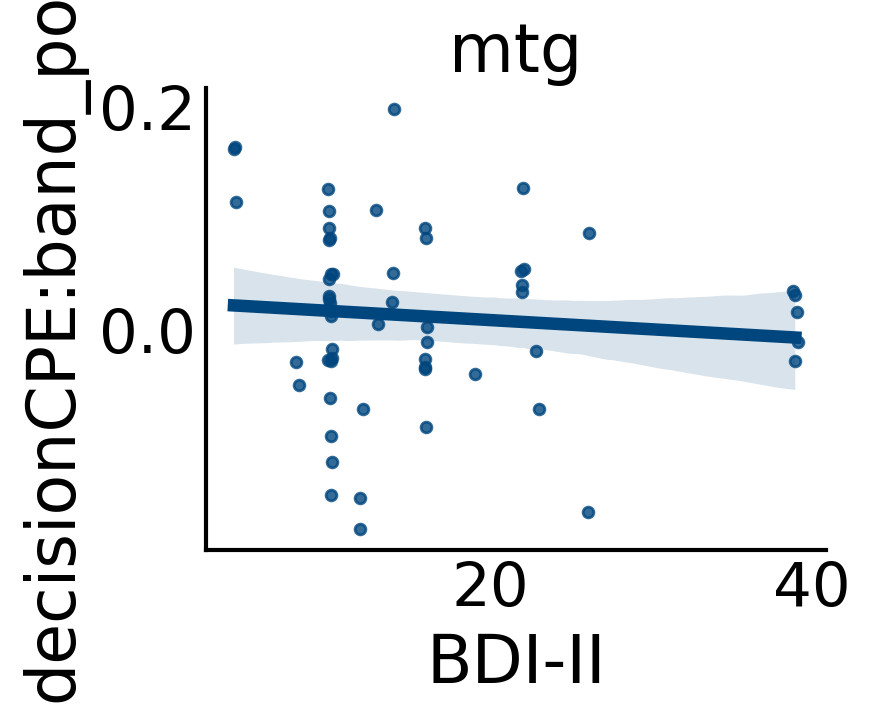

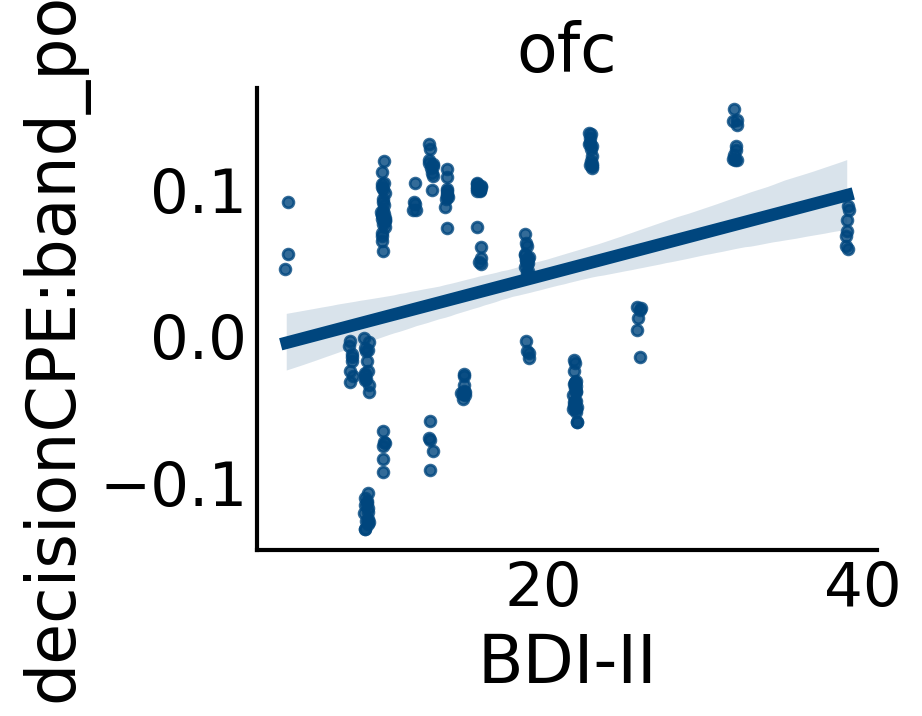

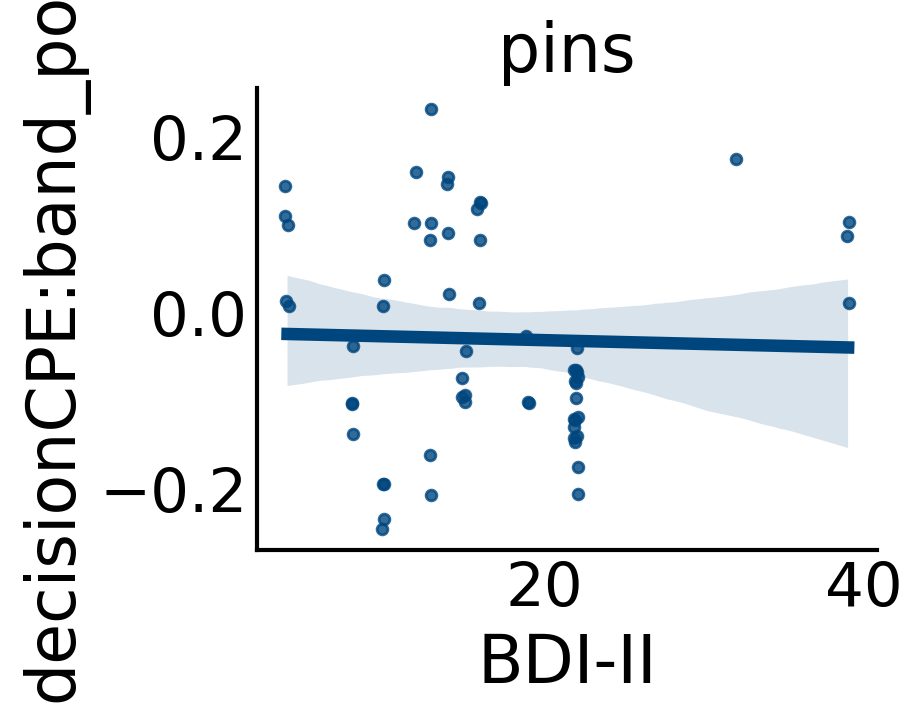

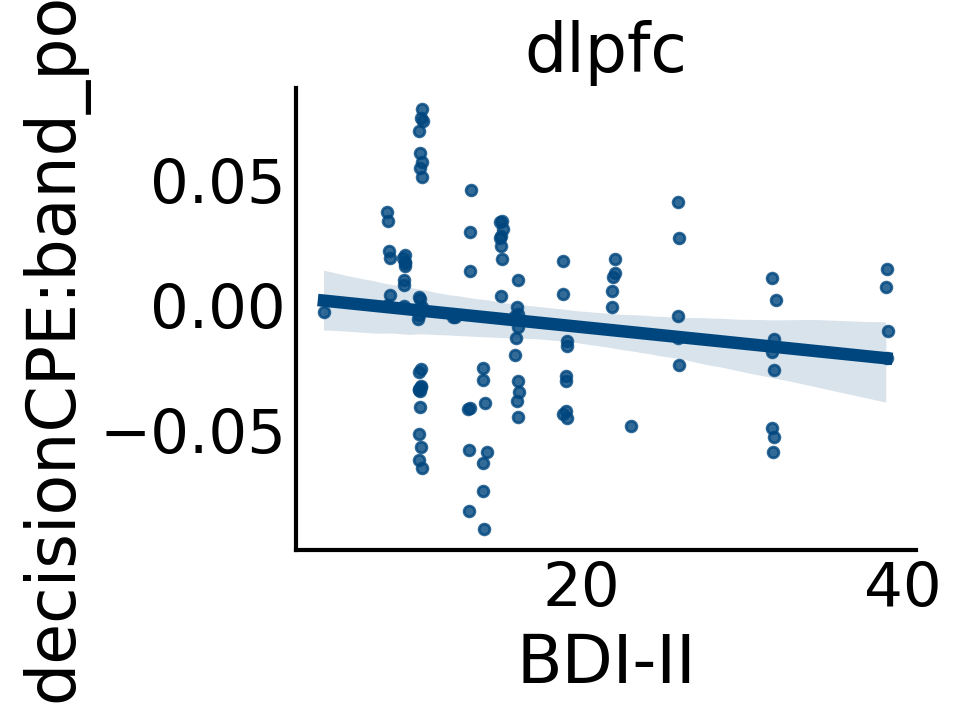

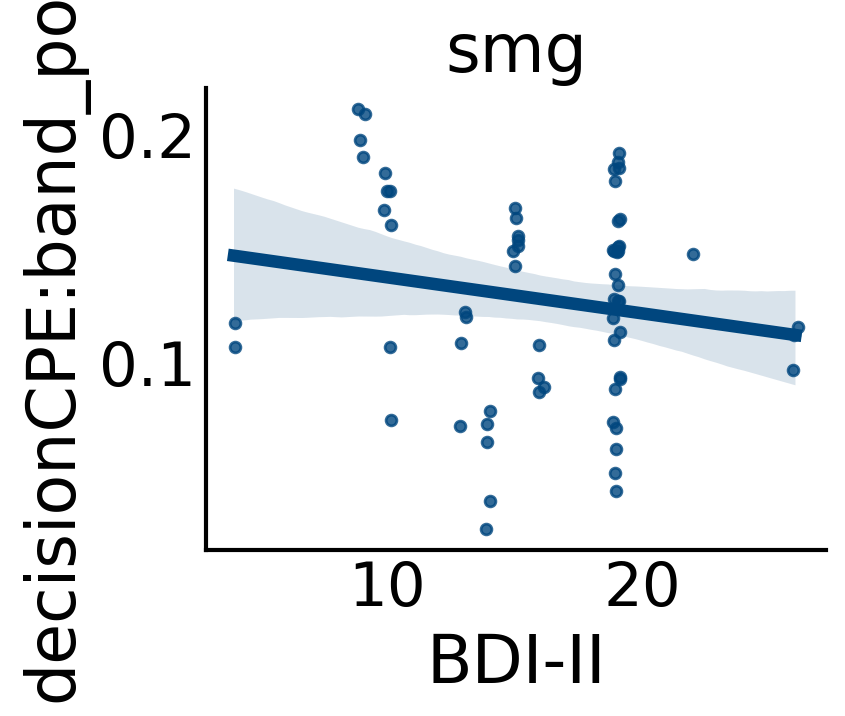

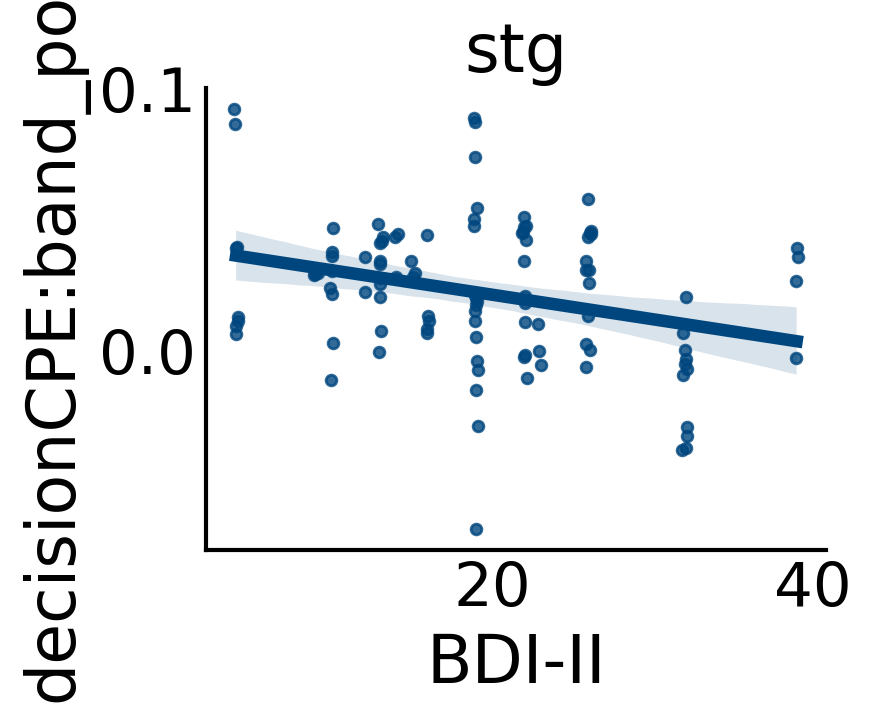

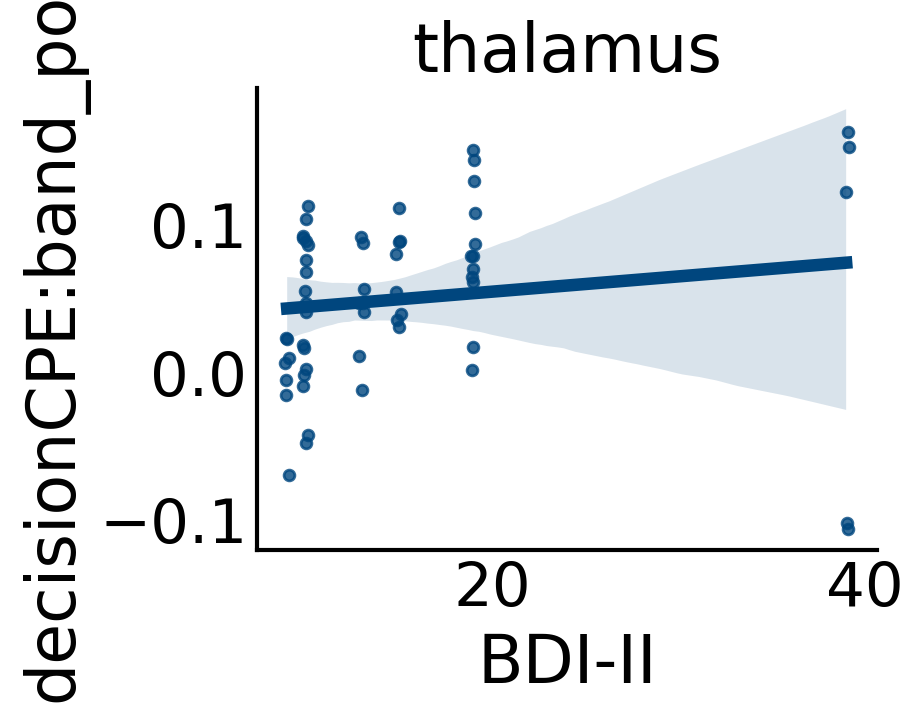

In [61]:

sns.set_context("poster",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE:band_pow',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':15}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    